In [1]:
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np

In [2]:
tsla = yf.Ticker('TSLA')
tsla_data = tsla.history(period='5y')
tsla_data.reset_index(inplace=True)
tsla_data.head

<bound method NDFrame.head of            Date        Open        High         Low       Close     Volume  \
0    2017-11-10   20.166668   20.557333   20.123333   20.199333   69381000   
1    2017-11-13   20.008667   21.120001   19.940666   21.026667  113773500   
2    2017-11-14   21.000000   21.090000   20.459999   20.580000   85141500   
3    2017-11-15   20.400667   20.832666   20.100000   20.753332   89680500   
4    2017-11-16   20.932667   21.209333   20.753332   20.833332   87331500   
...         ...         ...         ...         ...         ...        ...   
1253 2022-11-03  211.360001  221.199997  210.139999  215.309998   56538800   
1254 2022-11-04  222.600006  223.800003  203.080002  207.470001   98453100   
1255 2022-11-07  208.649994  208.899994  196.660004  197.080002   93916500   
1256 2022-11-08  194.020004  195.199997  186.750000  191.300003  128803400   
1257 2022-11-09  190.774994  195.889999  177.130005  177.589996  125228490   

      Dividends  Stock Splits  
0

Text(0, 0.5, 'Prices ($)')

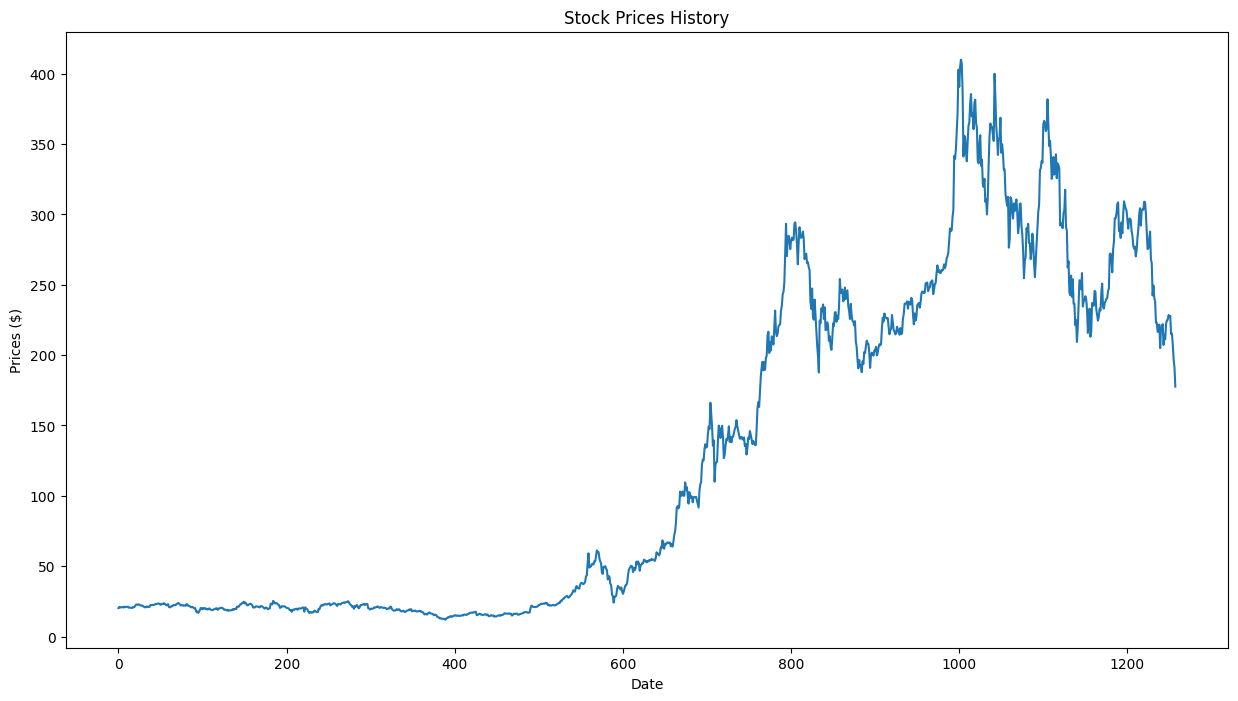

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(tsla_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [4]:
close_data = tsla_data.iloc[:,4].values.reshape(-1,1)
volume_data = tsla_data.iloc[:,5].values.reshape(-1,1)
open_data = tsla_data.iloc[:,1].values.reshape(-1,1)
#extract the Close Price and The volume for that day

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_volume = scaler.fit_transform(volume_data)
scaled_open = scaler.fit_transform(open_data)
scaled_close = scaler.fit_transform(close_data)

In [7]:
scaled_data = []

for i in range(0,len(scaled_close)):
    scaled_data.append([scaled_close[i],scaled_open[i],scaled_volume[i]])

scaled_data = np.array(scaled_data).squeeze()

In [8]:
scaled_data.shape

(1258, 3)

In [9]:
train_split = .7
train_data = scaled_data[0:int(train_split*len(scaled_data))]
train_data_len = len(train_data)


In [10]:
input_vector_length = 50

x_train = []
y_train = []

for i in range(input_vector_length,len(train_data)):
    x_train.append(train_data[i-input_vector_length:i])
    y_train.append(train_data[i,0]) ## add the 0 here to chop off the volume, only want the volume as input

x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
x_train.shape

(830, 50, 3)

In [12]:
test_data = scaled_data[int(train_split*len(scaled_data)) - input_vector_length: , :]
test_data_len = len(test_data)
x_test = []
y_test = test_data[input_vector_length:,0]

for i in range(input_vector_length,len(test_data)):
    x_test.append(test_data[i-input_vector_length:i])

x_test = np.array(x_test)

In [13]:
import keras
from keras import layers

In [14]:
model = keras.Sequential()

model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(layers.LSTM(100, return_sequences = False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           41600     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 124,551
Trainable params: 124,551
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',loss = 'mean_squared_error')
model.fit(x_train,y_train, batch_size = 1, epochs = 10)

Epoch 1/10
830/830 [==============================] - 30s 31ms/step - loss: 0.0019
Epoch 2/10
830/830 [==============================] - 25s 30ms/step - loss: 9.3733e-04
Epoch 3/10
830/830 [==============================] - 25s 30ms/step - loss: 0.0012
Epoch 4/10
830/830 [==============================] - 25s 30ms/step - loss: 5.1330e-04
Epoch 5/10
830/830 [==============================] - 25s 30ms/step - loss: 5.7354e-04
Epoch 6/10
830/830 [==============================] - 26s 31ms/step - loss: 4.8545e-04
Epoch 7/10
830/830 [==============================] - 26s 31ms/step - loss: 4.8165e-04
Epoch 8/10
830/830 [==============================] - 27s 32ms/step - loss: 5.1541e-04
Epoch 9/10
830/830 [==============================] - 29s 35ms/step - loss: 3.7911e-04
Epoch 10/10
830/830 [==============================] - 29s 35ms/step - loss: 3.3230e-04


In [44]:
test_predictions = model.predict(x_test)
train_predictions = model.predict(x_train)
test_predictions = scaler.inverse_transform(test_predictions)
train_predictions = scaler.inverse_transform(train_predictions)
rmse = np.sqrt(np.mean(test_predictions - y_test)**2)
rmse

241.32605742677876

C:\Users\dksil\AppData\Local\Temp\ipykernel_26544\519884937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = test_predictions


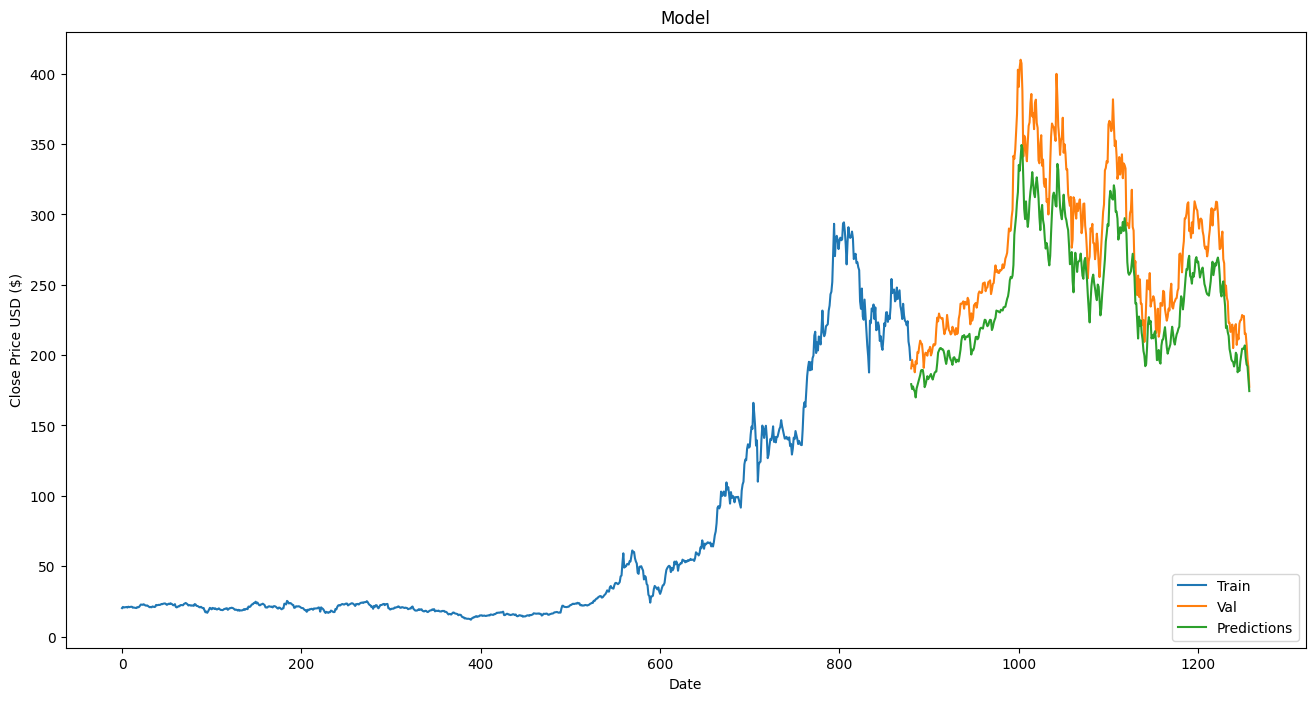

In [45]:
data = tsla_data.filter(['Close'])
train = data[:train_data_len]
validation = data[train_data_len:]
validation['Predictions'] = test_predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [79]:
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

url = 'https://finviz.com/quote.ashx?t=TSLA'

req = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
html = soup(webpage,"html.parser")

In [71]:
pred_appended_data = tsla_data[input_vector_length:]
predictions = np.append(train_predictions, test_predictions)

pred_appended_data['Predictions'] = predictions

labels = []
for i in range(0,len(pred_appended_data)):
    row = pred_appended_data.iloc[i]
    if row['Close'] > row['Open']:
        labels.append(1)
    else:
        labels.append(0)

training_data = pred_appended_data

C:\Users\dksil\AppData\Local\Temp\ipykernel_26544\3268723514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_appended_data['Predictions'] = predictions


In [64]:
training_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Predictions
50,2018-01-25,23.218000,23.280001,22.426666,22.509333,101104500,0,0.0,31.886572
51,2018-01-26,22.766666,22.933332,22.380667,22.856667,68091000,0,0.0,31.284286
52,2018-01-29,22.656668,23.389999,22.552000,23.302000,71206500,0,0.0,31.386236
53,2018-01-30,23.009333,23.218000,22.811333,23.054667,70765500,0,0.0,31.753860
54,2018-01-31,23.167334,23.746000,23.012667,23.620667,93211500,0,0.0,31.833393


In [65]:
prev_day_indicators = ['High', 'Low', 'Close','Volume','Stock Splits','Dividends']

# for col_name in prev_day_indicators:
#     print(col_name)
#     training_data['Prev Day ' + col_name] = training_data[col_name].shift(periods=1)
#     training_data = training_data.drop([col_name], axis=1)

High
Low
Close
Volume
Stock Splits
Dividends


C:\Users\dksil\AppData\Local\Temp\ipykernel_26544\3227377771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Prev Day ' + col_name] = training_data[col_name].shift(periods=1)


In [72]:
training_data = training_data[1:] # remove the empty first row
labels = labels[1:] # remove the corresponding prediction
training_data = training_data.drop(["Date"], axis=1)

In [73]:
print(len(labels))
training_data.info()
training_data.head()

1207
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 51 to 1257
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1207 non-null   float64
 1   High          1207 non-null   float64
 2   Low           1207 non-null   float64
 3   Close         1207 non-null   float64
 4   Volume        1207 non-null   int64  
 5   Dividends     1207 non-null   int64  
 6   Stock Splits  1207 non-null   float64
 7   Predictions   1207 non-null   float32
dtypes: float32(1), float64(5), int64(2)
memory usage: 70.9 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Predictions
51,22.766666,22.933332,22.380667,22.856667,68091000,0,0.0,31.284286
52,22.656668,23.389999,22.552000,23.302000,71206500,0,0.0,31.386236
53,23.009333,23.218000,22.811333,23.054667,70765500,0,0.0,31.753860
54,23.167334,23.746000,23.012667,23.620667,93211500,0,0.0,31.833393
55,23.400000,23.977333,23.242001,23.283333,62965500,0,0.0,31.932934


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3,random_state=109) # 70% training and 30% test

scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

#Create a random forest classifier
clf = SVC() # Linear Kernel


param_dict_svm = {
    'C': [0.1,1, 10, 100],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['linear','rbf', 'poly', 'sigmoid'],
}

grid = GridSearchCV(clf,param_dict_svm,refit=True,verbose=2)
grid.fit(X_train,y_train)

y_pred = grid.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

In [76]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

0.7823691460055097
[[ 98  22]
 [ 57 186]]
